# Brain tumor progression dataset

## I. Introduction

Contains datasets from 20 subjects with newly diagnosed glioblastoma who were treated with surgery and standard concomitant chemo-radiation therapy (CRT) followed by adjuvant chemotherapy. 
-Two MRI exams are included for each patient: within 90 days following CRT completion and at progression (determined clinically, and based on a combination of clinical performance and/or imaging findings, and punctuated by a change in treatment or intervention). 

All image sets are in DICOM format and contain T1w (pre and post-contrast agent), FLAIR, T2w, ADC, normalized cerebral blood flow, normalized relative cerebral blood volume, standardized relative cerebral blood volume, and binary tumor masks (generated using T1w images).  

There are **two main types of MRI images** :

-**T1 weighted**:
Grey matter is grey, white matter is lighter, fat looks bright, fliuds look dark.

-**T2 weighted**:
Gray matter is lighter than white matter, fat looks darker, fliuds look bright.

The Cerebrospinal fluid CSF for example will appear white in a T2 weighted image.

### Goal : Detect and delimit brain tumors as glioblastoma which are generally of bad prognostic especially for old patients. This can help physician to gain time as the MRI exam generally contains more than hundred images to interpret


## II. Loading and preprocess data

### Install packages

In [1]:
#Import librairies
import numpy as np
import math
import matplotlib.pyplot as plt
#!python -m pip install pydicom
import pydicom
from pydicom.data import get_testdata_files
# Get a list of files for all modalities individually
import glob
#!pip install pydicom
import pydicom as dicom
#import PIL # optional
import pandas as pd
#import csv
import os, shutil
import cv2
import matplotlib.pyplot as plt
import imageio
import os, shutil
import glob2
#import pydicom
import scipy.ndimage as ndi 
from tensorflow.keras.layers import Input
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler,EarlyStopping,TensorBoard,CSVLogger
from tensorflow.keras import backend as keras
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

In [8]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [31]:
#Path to the directory where the original dataset are
original_dataset_dir = 'D:\Brain_images\Brain-Tumor-Progression'

#Directory where we will store the dataset
base_dir_brain = 'D:/brain_small'  
#os.mkdir to create the folder in the specified path
#os.mkdir(base_dir_brain)

In [4]:
# Directories for the training, validation, and test splits
train_dir_brain = os.path.join(base_dir_brain, 'train_brain')                               
#os.mkdir(train_dir_brain)
validation_dir_brain = os.path.join(base_dir_brain, 'validation_brain')                      
#os.mkdir(validation_dir_brain)
test_dir_brain = os.path.join(base_dir_brain, 'test_brain')                                  
#os.mkdir(test_dir_brain)

We will select one patient who has a well-defined tumor to have a look of the brain image and the associated tumor-mask

In [33]:
#For stage 2 (1992), 1st patient, 18th dicom file "1-18.dcm"
PathDicom_image = "D:/Brain-Tumor-Progression/PGBM-001/04-02-1992-FH-HEADBrain Protocols-79896/37908.000000-T2reg-21119/1-18.dcm"
def getPixelDataFromDicom(filename):
    return pydicom.read_file(filename).pixel_array

Let's see for this specific brain image slice the pixels intensity values

In [7]:
array_dcm_image1=getPixelDataFromDicom(PathDicom_image)
print("Shape of the image {}".format(array_dcm_image1.shape))
print("The minimum pixel intensity of the image is {}".format(array_dcm_image1.min()))
print("The maximum pixel intensity of the image is {}".format(array_dcm_image1.max()))

Shape of the image (320, 260)
The minimum pixel intensity of the image is 0
The maximum pixel intensity of the image is 1303


We may think to a way to normalize the pixels intensity values (here for example it goes from 0 to 1303). We will see that later 

In [8]:
####Plot histogram with the cumulative distribution of the nb of pixels for all intensities
# Import SciPy's "ndimage" module
import scipy.ndimage as ndi 
# Create a histogram, binned at each possible value
#hist = ndi.histogram(array_dcm_image1,min = 0 ,max = 1092 , bins = 256)
# Create a cumulative distribution function
#cdf = hist.cumsum() / hist.sum()
# Plot the histogram and CDF
#fig, axes = plt.subplots(2, 1, sharex=True)
#axes[0].plot(hist, label='Histogram')
#axes[1].plot(cdf, label='CDF')

We select then the tumor mask associated to the image to give us an idea of a brain image slice and its tumor

In [9]:
#Create a variable in which we put the path of the 1st slice of the Patient "PGBM 001"
from os.path import relpath
Path_mask_patient1="D:/Brain-Tumor-Progression/PGBM-001/04-02-1992-FH-HEADBrain Protocols-79896/5388.000000-MaskTumor-63335/1-18.dcm"

In [11]:
#Small function to display the pixels values from the dicom file       
def getPixelDataFromDicom(filename):
    return dicom.read_file(filename).pixel_array

Shape of the image (320, 260)
The minimum pixel intensity of the image is 0
The maximum pixel intensity of the image is 1


[]

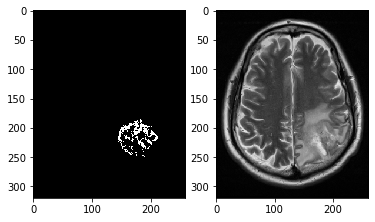

In [13]:
#The mask_patient1 contains the image of the mask
mask_patient1=getPixelDataFromDicom(Path_mask_patient1)
print("Shape of the image {}".format(mask_patient1.shape))
print("The minimum pixel intensity of the image is {}".format(mask_patient1.min()))
print("The maximum pixel intensity of the image is {}".format(mask_patient1.max()))

# Plot the brain image and the tumor mask
fig, axes = plt.subplots(1,2)
axes[0].imshow(mask_patient1,cmap="gray")
axes[1].imshow(array_dcm_image1,cmap = "gray")
plt.plot()

We can see the tumor associated which is quite big. We also notice that the mask pixels intensity are binary with values of 0 or 1. 

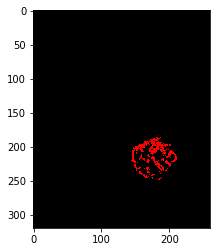

In [39]:
#Convert mask as a 3d channel image (R,G,B) or Red, Green, Blue
#To convert the image in red we keep the pixel intensity for the 1st channel (red), and we put zeros values for the 2 remaining channels (Green and Blue). 
#As we want a red tumor mask without green and blue
mask_patient1_red = np.zeros((np.array(mask_patient1).shape[0], np.array(mask_patient1).shape[1],3 ) )
mask_patient1_red[:,:,0] = mask_patient1 #Fill the 1st channel (red) with the initial gray pixels values
mask_patient1_red=np.array(mask_patient1_red)

#Show the mask, appears now in red
plt.imshow(mask_patient1_red)  

In [380]:
#We can see now that the image has 3 channels for RGB (with Green and Blue channel at zero has the image is made only with red)
mask_patient1_red.shape

(320, 260, 3)

In [43]:
#Function to normalize pixel intensity (from 0 to 255)
def normalize(image):
    pixels = np.asarray(image)
    # convert from integers to floats
    pixels = pixels.astype('float32')
    # normalize to the range 0-255
    pixels_max, pixels_min = pixels.max(), pixels.min()
    pixels = pixels.astype('int')
    pixels_norm = (pixels-pixels_min)*(255/(pixels_max-pixels_min))
    pixels_norm = pixels_norm.astype('int')
    return pixels_norm
#("Shape of the image {}".format(pixels_norm.shape)),("The pixel intensity range of the image before normalization is {}-{}".format(pixels.min(),pixels.max())),("The pixel intensity range of the image after normalization is {}-{}".format(pixels_norm.min(),pixels_norm.max()))

In [44]:
#Try the function returns normalized image
image_norm=normalize(array_dcm_image1)
image_norm

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

We would want now to **"overlay"** or **to superpose** the **brain image** with its **associated tumor mask** to better see how the image looks.

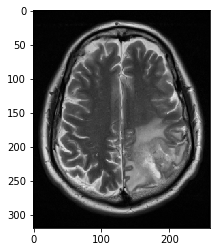

In [47]:
#Now after the image has been normalized to a 0-255 range, as we want to overlay a colored mask the 2 images have to have the same dimensions (3 channels).
#so we have to convert the brain image  to a "pseudo" RGB image by duplicating the pixel intensity in the 3 channel which will generate a gray image.
pixels_rgb = np.zeros( ( np.array(image_norm).shape[0], np.array(image_norm).shape[1], 3 ) )
pixels_rgb[:,:,0] = image_norm # same value in each channel
pixels_rgb[:,:,1] = image_norm
pixels_rgb[:,:,2] = image_norm
pixels_rgb.shape
#display the image with matplotlib function plt.imshow
plt.imshow(pixels_rgb.astype(np.uint8)) 

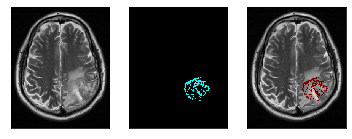

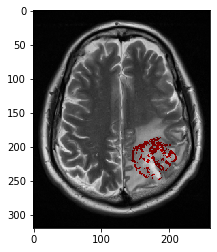

In [51]:
from skimage import data, color, io, img_as_float
color_mask=mask_patient1_red
# Convert the input image and color mask to Hue Saturation Value (HSV)
# colorspace
img_hsv = color.rgb2hsv(pixels_rgb)
color_mask_hsv = color.rgb2hsv(mask_patient1_red)

# Replace the hue and saturation of the original image
# with that of the color mask
img_hsv[..., 0] = color_mask_hsv[..., 0]
img_hsv[..., 1] = color_mask_hsv[..., 1] 
img_masked = color.hsv2rgb(img_hsv)

f, (ax0, ax1, ax2) = plt.subplots(1, 3,
                                  subplot_kw={'xticks': [], 'yticks': []})
ax0.imshow(pixels_rgb.astype(np.uint8), cmap=plt.cm.gray)
ax1.imshow(color_mask_hsv)
ax2.imshow(img_masked.astype(np.uint8))
plt.show()
#Save image
# Filename 
filename = 'overlay_image.jpg'
# Using cv2.imwrite() method 
# Saving the image 
#cv2 seems to save image in BGR format so use plt.imsave
plt.imsave(filename, img_masked.astype(np.uint8)) 
plt.imshow(img_masked.astype(np.uint8))

### Creating directories to put data inside

In [56]:
#Path to the directory where the original dataset are
original_dataset_dir = '../Brain-Tumor-Progression'
#Directory where we will store the dataset
base_dir_brain = '../brain_small'  
#os.mkdir to create the folder in the specified path
#os.mkdir(base_dir_brain)

In [ ]:
# Directories for the training, validation, and test splits
train_dir_brain = os.path.join(base_dir_brain, 'train_brain')                               
os.mkdir(train_dir_brain)
validation_dir_brain = os.path.join(base_dir_brain, 'validation_brain')                      
os.mkdir(validation_dir_brain)
test_dir_brain = os.path.join(base_dir_brain, 'test_brain')                                  
os.mkdir(test_dir_brain)

### Transfer files into the folders

In [376]:
#Sort and load scans for 1 patient in stage 1    
def load_scan2(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

PathDicom_image_stage1 = "D:/Brain_images/Brain-Tumor-Progression/PGBM-001/11-19-1991-FH-HEADBrain Protocols-40993/11-T1post-03326"

slices_patient1=load_scan(PathDicom_image_stage1)

**Pixel spacing** is a vector of 2 elements the 1st value is the **row spacing** the 2nd one is the **column spacing**. The row spacing is the **space between 2 centers pixels** from one row to another. Vice-versa for the column spacing.

In [287]:
#Spacing of the scan
spacing = map(float, ([slices_patient1[0].SliceThickness] + list(slices_patient1[0].PixelSpacing)))
slices_patient1[0].SliceThickness #Slice thickness in mm
slices_patient1[0].PixelSpacing

[0.6875, 0.6875]

In [288]:
#spacing of the tumor
PathDicom_image_tumor = "D:/Brain_images/Brain-Tumor-Progression/PGBM-001/11-19-1991-FH-HEADBrain Protocols-40993/5364-MaskTumor-94345"

slices_tumor_patient1=load_scan(PathDicom_image_tumor)
spacing_tumor = map(float, ([slices_tumor_patient1[0].SliceThickness] + list(slices_tumor_patient1[0].PixelSpacing)))
slices_tumor_patient1[0].PixelSpacing

[0.687500, 0.687500]

It seems spacing of the tumor and spacing of the mri are same so resampling is not necessary

In [289]:
(slices_tumor_patient1[0].pixel_array).shape

(320, 260)

In [249]:
def get_pixels(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    
    return np.array(image, dtype=np.int32)

#Get the pixels values from the scan of the 1st patient
id=0
imgs = get_pixels(slices_patient1)

In [291]:
#Save the image file as numpy array
output_path="D:/Brain_small/train_brain/"
np.save(output_path + "fullimages_%d.npy" % (id), imgs)
imgs.shape

(25, 320, 260)

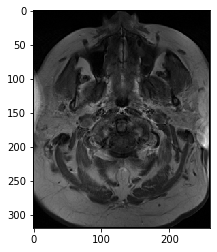

In [292]:
#Display the "1st scan's slice" of the 1st patient
plt.imshow(imgs[0])

In [293]:
#Re-sample image by transforming current spacing into [1,1,1]
new_spacing=[1,1,1]
spacing = np.array(list(spacing))
new_spacing = np.array(list(new_spacing))
resize_factor = spacing / new_spacing
new_real_shape = imgs.shape * resize_factor
new_shape = np.round(new_real_shape)
real_resize_factor = new_shape / array_dcm_image1[0].shape
new_spacing = spacing / real_resize_factor
import scipy.ndimage as ndi 

image_resampled = ndi.interpolation.zoom(imgs, real_resize_factor)

In [294]:
#Before re-sampling image
print("Shape of the image before resampling is {}".format(imgs.shape))

#after resampling
print("Shape of the resample image is {}".format(image_resampled.shape))

Shape of the image before resampling is (25, 320, 260)
Shape of the resample image is (15, 271, 179)


In [247]:
PathDicom_image_stage1 = "D:/Brain-Tumor-Progression - Backup/PGBM-001/11-19-1991-FH-HEADBrain Protocols-40993/11.000000-T1post-03326"
slices_patient1=load_scan(PathDicom_image_stage1)
PathDicom_image_stage2 = "D:/Brain-Tumor-Progression - Backup/PGBM-001/04-02-1992-FH-HEADBrain Protocols-79896/11.000000-T1post-80644"
slices_patient2=load_scan(PathDicom_image_stage2)

In [256]:
#Same for Mask tumor
Path_mask_stage1 = "D:/Brain-Tumor-Progression - Backup/PGBM-001/11-19-1991-FH-HEADBrain Protocols-40993/5364.000000-MaskTumor-94345"
slices_mask1=load_scan(Path_mask_stage1)
Path_mask_stage2 = "D:/Brain-Tumor-Progression - Backup/PGBM-001/04-02-1992-FH-HEADBrain Protocols-79896/5388.000000-MaskTumor-63335"
slices_mask2=load_scan(Path_mask_stage2)

In [260]:
imgs_mask_stage1 = get_pixels(slices_mask1)
#Save the image file as numpy array
output_path="D:/Brain_small/train_brain/"
np.save(output_path + "fullimages_mask_stage1%d.npy" % (id), imgs_mask_stage1)
imgs_mask_stage1.shape

(25, 320, 260)

In [262]:
imgs_mask_stage2 = get_pixels(slices_mask2)
#Save the image file as numpy array
output_path="D:/Brain_small/train_brain/"
np.save(output_path + "fullimages_mask_stage2%d.npy" % (id), imgs_mask_stage2)
imgs_mask_stage2.shape

(24, 320, 260)

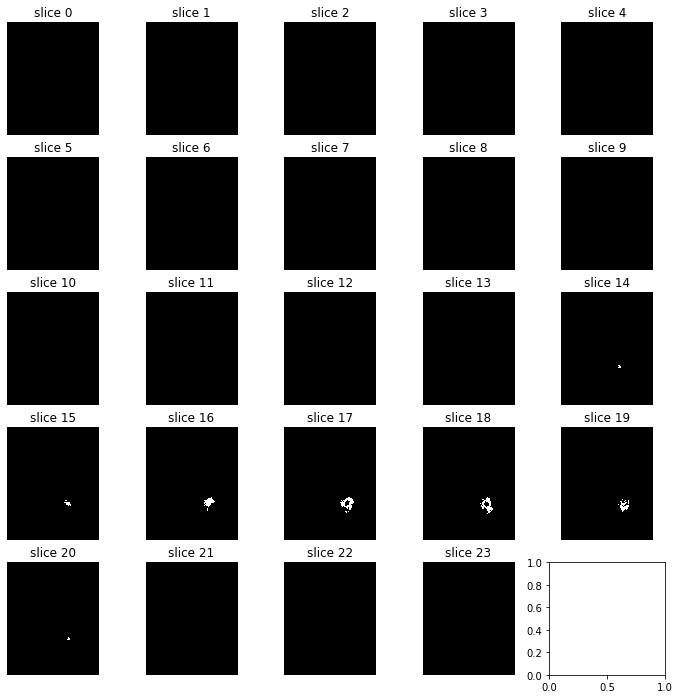

In [261]:
#Show scans for 1st patient before re-sampling
imgs_mask_stage1 = np.load(output_path+'fullimages_mask_stage1{}.npy'.format(id))
def sample_stack(stack, rows=5, cols=5, start_with=0, show_every=1):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols-1):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()
sample_stack(imgs_mask_stage1)

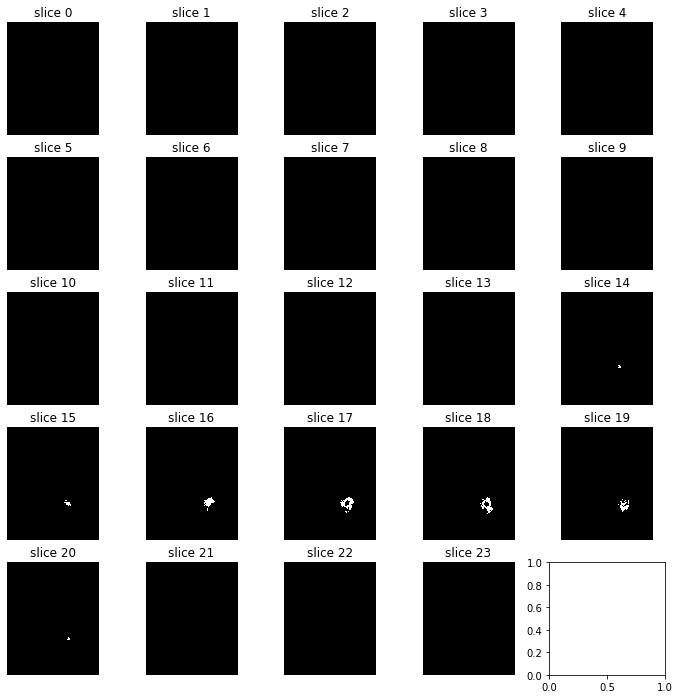

In [264]:
#Show scans for 1st patient mask tumor stage 2
imgs_mask_stage2 = np.load(output_path+'fullimages_mask_stage2{}.npy'.format(id))
def sample_stack(stack, rows=5, cols=5, start_with=0, show_every=1):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols-1):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()
sample_stack(imgs_mask_stage1)

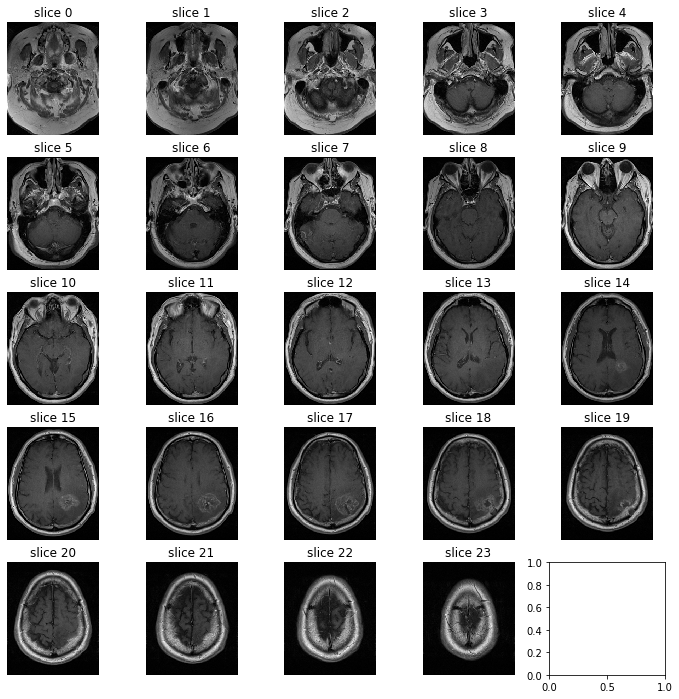

In [255]:
#Show scans for 1st patient before re-sampling
imgs_to_process_stage2 = np.load(output_path+'fullimages_{}.npy'.format(id))
def sample_stack(stack, rows=5, cols=5, start_with=0, show_every=1):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols-1):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()
sample_stack(imgs_to_process_stage2)

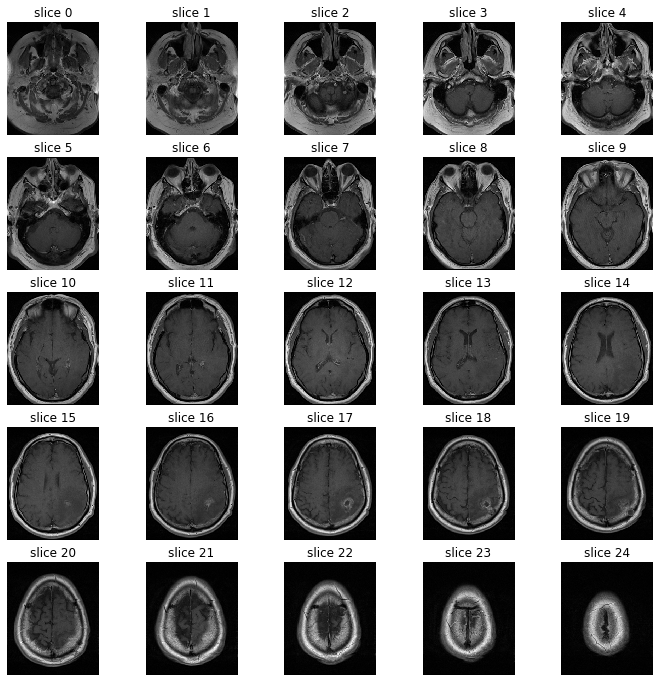

In [295]:
#Show scans for 1st patient before re-sampling
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))
def sample_stack(stack, rows=5, cols=5, start_with=0, show_every=1):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()
sample_stack(imgs_to_process)

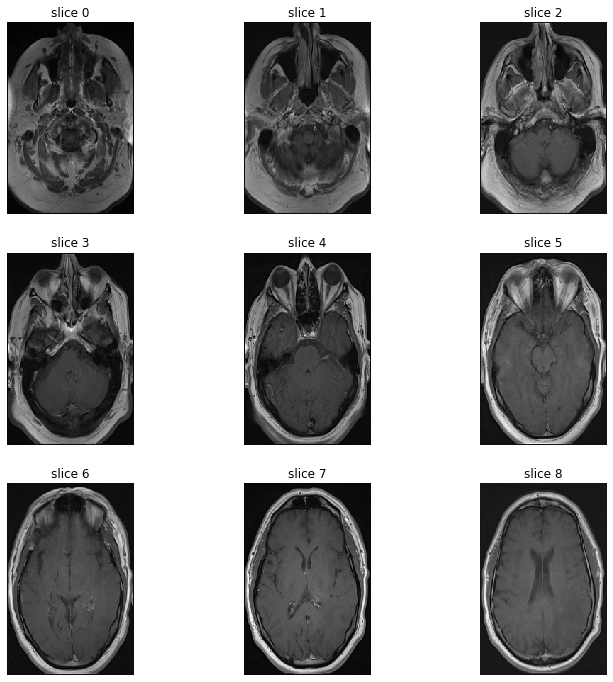

In [296]:
#After re-sampling
sample_stack(image_resampled,rows=3, cols=3, start_with=0, show_every=1)

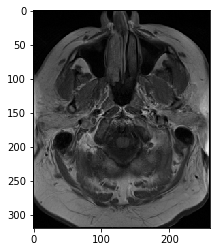

In [297]:
#Couldn't plot overlay (with tumor in red for example) !
redMask = cv2.bitwise_and(imgs[1], imgs[1], mask=im_Mask_Tumor)
red_im=cv2.addWeighted(redMask, 0.1, imgs[1], 0.7, 0.9, imgs[1])
plt.imshow(red_im)

In [5]:
#Define patterns for patients, stages, modalities and dicom_files
import glob2
patients=glob2.glob("D:\\Brain_images\\Brain-Tumor-Progression\\*")
stages=glob2.glob("D:\\Brain_images\\Brain-Tumor-Progression\\PGBM-0**\\*")
modalities_T1post = glob2.glob("D:\\Brain_images\\Brain-Tumor-Progression\\PGBM-0**\\*\\*T1post*\\")
modalities_T2reg =glob2.glob("D:\\Brain_images\\Brain-Tumor-Progression\\PGBM-0*\\*\\*T2reg*\\")
mask_tumor=glob2.glob("D:\\Brain_small\\folder_brain\\*MaskTumor*.dcm")

dicom_files=glob2.glob("D:\\Brain_images\\Brain-Tumor-Progression\\PGBM-0**\\*\\*T1post*\\*.dcm")

In [661]:
#Print filename (without path)
for i in range(len(modalities)):
       for path in glob2.glob(os.path.join(modalities[i],"*.dcm")):
            file_name = os.path.split(path)[-1]
            print(file_name)

1-01.dcm
1-02.dcm
1-03.dcm
1-04.dcm
1-05.dcm
1-06.dcm
1-07.dcm
1-08.dcm
1-09.dcm
1-10.dcm
1-11.dcm
1-12.dcm
1-13.dcm
1-14.dcm
1-15.dcm
1-16.dcm
1-17.dcm
1-18.dcm
1-19.dcm
1-20.dcm
1-21.dcm
1-22.dcm
1-23.dcm
1-24.dcm
1-01.dcm
1-02.dcm
1-03.dcm
1-04.dcm
1-05.dcm
1-06.dcm
1-07.dcm
1-08.dcm
1-09.dcm
1-10.dcm
1-11.dcm
1-12.dcm
1-13.dcm
1-14.dcm
1-15.dcm
1-16.dcm
1-17.dcm
1-18.dcm
1-19.dcm
1-20.dcm
1-21.dcm
1-22.dcm
1-23.dcm
1-24.dcm
1-25.dcm
1-01.dcm
1-02.dcm
1-03.dcm
1-04.dcm
1-05.dcm
1-06.dcm
1-07.dcm
1-08.dcm
1-09.dcm
1-10.dcm
1-11.dcm
1-12.dcm
1-13.dcm
1-14.dcm
1-15.dcm
1-16.dcm
1-17.dcm
1-18.dcm
1-19.dcm
1-20.dcm
1-21.dcm
1-22.dcm
1-01.dcm
1-02.dcm
1-03.dcm
1-04.dcm
1-05.dcm
1-06.dcm
1-07.dcm
1-08.dcm
1-09.dcm
1-10.dcm
1-11.dcm
1-12.dcm
1-13.dcm
1-14.dcm
1-15.dcm
1-16.dcm
1-17.dcm
1-18.dcm
1-19.dcm
1-20.dcm
1-21.dcm
1-22.dcm
1-01.dcm
1-02.dcm
1-03.dcm
1-04.dcm
1-05.dcm
1-06.dcm
1-07.dcm
1-08.dcm
1-09.dcm
1-10.dcm
1-11.dcm
1-12.dcm
1-13.dcm
1-14.dcm
1-15.dcm
1-16.dcm
1-17.dcm
1-18.dcm
1

In [719]:
#Print complete path with filename
dcm_files=glob2.glob(os.path.join(modalities[i],"*.dcm"))
for i in range(len(modalities)):
    for path in list(dcm_files):
        print(path)

D:\Brain_images\Brain-Tumor-Progression\PGBM-020\11-09-1989-HEADBrain Protocols-61674\11.000000-T1post-92351\1-01.dcm
D:\Brain_images\Brain-Tumor-Progression\PGBM-020\11-09-1989-HEADBrain Protocols-61674\11.000000-T1post-92351\1-02.dcm
D:\Brain_images\Brain-Tumor-Progression\PGBM-020\11-09-1989-HEADBrain Protocols-61674\11.000000-T1post-92351\1-03.dcm
D:\Brain_images\Brain-Tumor-Progression\PGBM-020\11-09-1989-HEADBrain Protocols-61674\11.000000-T1post-92351\1-04.dcm
D:\Brain_images\Brain-Tumor-Progression\PGBM-020\11-09-1989-HEADBrain Protocols-61674\11.000000-T1post-92351\1-05.dcm
D:\Brain_images\Brain-Tumor-Progression\PGBM-020\11-09-1989-HEADBrain Protocols-61674\11.000000-T1post-92351\1-06.dcm
D:\Brain_images\Brain-Tumor-Progression\PGBM-020\11-09-1989-HEADBrain Protocols-61674\11.000000-T1post-92351\1-07.dcm
D:\Brain_images\Brain-Tumor-Progression\PGBM-020\11-09-1989-HEADBrain Protocols-61674\11.000000-T1post-92351\1-08.dcm
D:\Brain_images\Brain-Tumor-Progression\PGBM-020\11-09-1

In [612]:
#Print path without filename
for i in range(len(modalities)):
    for path in glob2.glob(os.path.join(modalities[i],"*.dcm")):
        path_without_filename=os.path.dirname(path)
        print(path_without_filename)

D:\Brain_images\Brain-Tumor-Progression\PGBM-001\04-02-1992-FH-HEADBrain Protocols-79896\11.000000-T1post-80644
D:\Brain_images\Brain-Tumor-Progression\PGBM-001\04-02-1992-FH-HEADBrain Protocols-79896\11.000000-T1post-80644
D:\Brain_images\Brain-Tumor-Progression\PGBM-001\04-02-1992-FH-HEADBrain Protocols-79896\11.000000-T1post-80644
D:\Brain_images\Brain-Tumor-Progression\PGBM-001\04-02-1992-FH-HEADBrain Protocols-79896\11.000000-T1post-80644
D:\Brain_images\Brain-Tumor-Progression\PGBM-001\04-02-1992-FH-HEADBrain Protocols-79896\11.000000-T1post-80644
D:\Brain_images\Brain-Tumor-Progression\PGBM-001\04-02-1992-FH-HEADBrain Protocols-79896\11.000000-T1post-80644
D:\Brain_images\Brain-Tumor-Progression\PGBM-001\04-02-1992-FH-HEADBrain Protocols-79896\11.000000-T1post-80644
D:\Brain_images\Brain-Tumor-Progression\PGBM-001\04-02-1992-FH-HEADBrain Protocols-79896\11.000000-T1post-80644
D:\Brain_images\Brain-Tumor-Progression\PGBM-001\04-02-1992-FH-HEADBrain Protocols-79896\11.000000-T1pos

D:\Brain_images\Brain-Tumor-Progression\PGBM-004\01-12-1994-MR RCBV SEQUENCE FH-77052\12.000000-T1post-10326
D:\Brain_images\Brain-Tumor-Progression\PGBM-004\01-12-1994-MR RCBV SEQUENCE FH-77052\12.000000-T1post-10326
D:\Brain_images\Brain-Tumor-Progression\PGBM-004\01-12-1994-MR RCBV SEQUENCE FH-77052\12.000000-T1post-10326
D:\Brain_images\Brain-Tumor-Progression\PGBM-004\01-12-1994-MR RCBV SEQUENCE FH-77052\12.000000-T1post-10326
D:\Brain_images\Brain-Tumor-Progression\PGBM-004\01-12-1994-MR RCBV SEQUENCE FH-77052\12.000000-T1post-10326
D:\Brain_images\Brain-Tumor-Progression\PGBM-004\01-12-1994-MR RCBV SEQUENCE FH-77052\12.000000-T1post-10326
D:\Brain_images\Brain-Tumor-Progression\PGBM-004\01-12-1994-MR RCBV SEQUENCE FH-77052\12.000000-T1post-10326
D:\Brain_images\Brain-Tumor-Progression\PGBM-004\01-12-1994-MR RCBV SEQUENCE FH-77052\12.000000-T1post-10326
D:\Brain_images\Brain-Tumor-Progression\PGBM-004\01-12-1994-MR RCBV SEQUENCE FH-77052\12.000000-T1post-10326
D:\Brain_images\Bra

D:\Brain_images\Brain-Tumor-Progression\PGBM-007\02-17-1994-MR RCBV SEQUENCE-FH-22790\11.000000-T1post-04208
D:\Brain_images\Brain-Tumor-Progression\PGBM-007\02-17-1994-MR RCBV SEQUENCE-FH-22790\11.000000-T1post-04208
D:\Brain_images\Brain-Tumor-Progression\PGBM-007\02-17-1994-MR RCBV SEQUENCE-FH-22790\11.000000-T1post-04208
D:\Brain_images\Brain-Tumor-Progression\PGBM-007\02-17-1994-MR RCBV SEQUENCE-FH-22790\11.000000-T1post-04208
D:\Brain_images\Brain-Tumor-Progression\PGBM-007\02-17-1994-MR RCBV SEQUENCE-FH-22790\11.000000-T1post-04208
D:\Brain_images\Brain-Tumor-Progression\PGBM-007\02-17-1994-MR RCBV SEQUENCE-FH-22790\11.000000-T1post-04208
D:\Brain_images\Brain-Tumor-Progression\PGBM-007\02-17-1994-MR RCBV SEQUENCE-FH-22790\11.000000-T1post-04208
D:\Brain_images\Brain-Tumor-Progression\PGBM-007\02-17-1994-MR RCBV SEQUENCE-FH-22790\11.000000-T1post-04208
D:\Brain_images\Brain-Tumor-Progression\PGBM-007\02-17-1994-MR RCBV SEQUENCE-FH-22790\11.000000-T1post-04208
D:\Brain_images\Bra

D:\Brain_images\Brain-Tumor-Progression\PGBM-010\06-18-1992-FH-HEADBrain Protocols-39987\11.000000-T1post-86554
D:\Brain_images\Brain-Tumor-Progression\PGBM-010\06-18-1992-FH-HEADBrain Protocols-39987\11.000000-T1post-86554
D:\Brain_images\Brain-Tumor-Progression\PGBM-010\06-18-1992-FH-HEADBrain Protocols-39987\11.000000-T1post-86554
D:\Brain_images\Brain-Tumor-Progression\PGBM-010\06-18-1992-FH-HEADBrain Protocols-39987\11.000000-T1post-86554
D:\Brain_images\Brain-Tumor-Progression\PGBM-010\06-18-1992-FH-HEADBrain Protocols-39987\11.000000-T1post-86554
D:\Brain_images\Brain-Tumor-Progression\PGBM-010\06-18-1992-FH-HEADBrain Protocols-39987\11.000000-T1post-86554
D:\Brain_images\Brain-Tumor-Progression\PGBM-010\06-18-1992-FH-HEADBrain Protocols-39987\11.000000-T1post-86554
D:\Brain_images\Brain-Tumor-Progression\PGBM-010\06-18-1992-FH-HEADBrain Protocols-39987\11.000000-T1post-86554
D:\Brain_images\Brain-Tumor-Progression\PGBM-010\06-18-1992-FH-HEADBrain Protocols-39987\11.000000-T1pos

D:\Brain_images\Brain-Tumor-Progression\PGBM-013\11-14-1989-HEADBrain Protocols-84639\11.000000-T1post-26145
D:\Brain_images\Brain-Tumor-Progression\PGBM-013\11-14-1989-HEADBrain Protocols-84639\11.000000-T1post-26145
D:\Brain_images\Brain-Tumor-Progression\PGBM-013\11-14-1989-HEADBrain Protocols-84639\11.000000-T1post-26145
D:\Brain_images\Brain-Tumor-Progression\PGBM-013\11-14-1989-HEADBrain Protocols-84639\11.000000-T1post-26145
D:\Brain_images\Brain-Tumor-Progression\PGBM-013\11-14-1989-HEADBrain Protocols-84639\11.000000-T1post-26145
D:\Brain_images\Brain-Tumor-Progression\PGBM-013\11-14-1989-HEADBrain Protocols-84639\11.000000-T1post-26145
D:\Brain_images\Brain-Tumor-Progression\PGBM-013\11-14-1989-HEADBrain Protocols-84639\11.000000-T1post-26145
D:\Brain_images\Brain-Tumor-Progression\PGBM-013\11-14-1989-HEADBrain Protocols-84639\11.000000-T1post-26145
D:\Brain_images\Brain-Tumor-Progression\PGBM-013\11-14-1989-HEADBrain Protocols-84639\11.000000-T1post-26145
D:\Brain_images\Bra

D:\Brain_images\Brain-Tumor-Progression\PGBM-017\08-21-1997-MR RCBV SEQUENCE-73885\11.000000-T1post-07939
D:\Brain_images\Brain-Tumor-Progression\PGBM-017\08-21-1997-MR RCBV SEQUENCE-73885\11.000000-T1post-07939
D:\Brain_images\Brain-Tumor-Progression\PGBM-017\08-21-1997-MR RCBV SEQUENCE-73885\11.000000-T1post-07939
D:\Brain_images\Brain-Tumor-Progression\PGBM-017\08-21-1997-MR RCBV SEQUENCE-73885\11.000000-T1post-07939
D:\Brain_images\Brain-Tumor-Progression\PGBM-017\08-21-1997-MR RCBV SEQUENCE-73885\11.000000-T1post-07939
D:\Brain_images\Brain-Tumor-Progression\PGBM-017\08-21-1997-MR RCBV SEQUENCE-73885\11.000000-T1post-07939
D:\Brain_images\Brain-Tumor-Progression\PGBM-017\08-21-1997-MR RCBV SEQUENCE-73885\11.000000-T1post-07939
D:\Brain_images\Brain-Tumor-Progression\PGBM-017\08-21-1997-MR RCBV SEQUENCE-73885\11.000000-T1post-07939
D:\Brain_images\Brain-Tumor-Progression\PGBM-017\08-21-1997-MR RCBV SEQUENCE-73885\11.000000-T1post-07939
D:\Brain_images\Brain-Tumor-Progression\PGBM-0

D:\Brain_images\Brain-Tumor-Progression\PGBM-020\11-09-1989-HEADBrain Protocols-61674\11.000000-T1post-92351
D:\Brain_images\Brain-Tumor-Progression\PGBM-020\11-09-1989-HEADBrain Protocols-61674\11.000000-T1post-92351
D:\Brain_images\Brain-Tumor-Progression\PGBM-020\11-09-1989-HEADBrain Protocols-61674\11.000000-T1post-92351
D:\Brain_images\Brain-Tumor-Progression\PGBM-020\11-09-1989-HEADBrain Protocols-61674\11.000000-T1post-92351
D:\Brain_images\Brain-Tumor-Progression\PGBM-020\11-09-1989-HEADBrain Protocols-61674\11.000000-T1post-92351
D:\Brain_images\Brain-Tumor-Progression\PGBM-020\11-09-1989-HEADBrain Protocols-61674\11.000000-T1post-92351
D:\Brain_images\Brain-Tumor-Progression\PGBM-020\11-09-1989-HEADBrain Protocols-61674\11.000000-T1post-92351
D:\Brain_images\Brain-Tumor-Progression\PGBM-020\11-09-1989-HEADBrain Protocols-61674\11.000000-T1post-92351
D:\Brain_images\Brain-Tumor-Progression\PGBM-020\11-09-1989-HEADBrain Protocols-61674\11.000000-T1post-92351
D:\Brain_images\Bra

In [701]:
#Print path without filename
for i in range(len(modalities)):
    for path in glob2.glob(os.path.join(modalities[i],"*.dcm")):
        path_without_filename=os.path.dirname(path)
        file_name = os.path.split(path)[-1]
        print(path_without_filename)
        #print(path_without_filename)
        #for file in file_name:
         #   print(path+file)

Let's select for the moment **1 MRI modality : "T2reg"**. I will loop the paths through the defined pattern and rename the file names with the directory name and the previous file name to keep on the file-name the information 
about which patient,which stage and which MRI modality the dcm file belongs to.

**Example : "__PGBM-001_04-02-1992-FH-HEADBrain Protocols-79896_11.000000-T1post-80644_1-01.dcm"**

In [266]:
#Change every filenames for T2reg modality
for i in range((len(modalities_T2reg))):
    path_files=glob2.glob(os.path.join(modalities_T2reg[i],"*.dcm"))#Extract file paths with T2reg modality
    for path in path_files: #Loop into path_files
        file_name=os.path.basename(path) #Extract filename with os.path.basename function
        dir_name=os.path.dirname(path)   #Extract name of directory for each path
        dir_name_cleaned=dir_name.replace("D:\\Brain_images\\Brain-Tumor-Progression\\",'\\')#Remove the 1st part of the filename as it is not really necessary to identify each dcm file
        dir_name_cleaned=dir_name_cleaned.replace("\\","_")#In the filename replace "\\" by "_"
        source=path #Define the sources files (contains the path of the files we want the names to be modified)
        destination=(dir_name+"\\"+dir_name_cleaned+"_"+file_name)#the name we want to give for each files
        os.rename(source,destination)#os.rename function rename the files defined in "source" into the name defined in "destination"
print("name change succeeded !")#To confirm that the names have been changed

name change succeeded !


In [237]:
#Same procedure for mask tumor
import glob2
#As they are 2 stages by patients and 20 patients
for i in range((len(mask_tumor))):
    path_files=glob2.glob(os.path.join(mask_tumor[i],"*.dcm"))
    for path in path_files:
        file_name=os.path.basename(path)
        dir_name=os.path.dirname(path)
        dir_name_cleaned=dir_name.replace("D:\\Brain_images\\Brain-Tumor-Progression\\",'\\')
        dir_name_cleaned=dir_name_cleaned.replace("\\","_")
        source=path
        destination=(dir_name+"\\"+dir_name_cleaned+"_"+file_name)
        os.rename(source,destination)
print("name change succeeded !")

name change succeeded !


We then create a folder in which we will put the dcm files with the modified names containing the identifier of the Patient, the stage, the MRI modality and the slice id.

In [12]:
#Create the folder named "folder_brain" inside the base_dir_brain folder whose path is : 'D:\\brain_small'    
base_dir_brain = 'D:\\brain_small'               
folder_brain = os.path.join(base_dir_brain, 'folder_brain') 
#os.mkdir(folder_brain)

In [272]:
#Copy mask dcm files into the folder "folder_brain"
for i in range((len(mask_tumor))):
    for filename in glob2.glob(os.path.join(os.path.join(mask_tumor[i],"*.dcm"))):
        shutil.copy(filename, folder_brain)

In [274]:
#Same for T2reg copy dcm files into "folder_brain"
for i in range((len(modalities_T2reg))):
    for filename in glob2.glob(os.path.join(os.path.join(modalities_T2reg[i],"*.dcm"))):
        shutil.copy(filename, folder_brain)

In [293]:
#Create a function that returns a list of files from a directory(root_dir) and several patterns defined with glob
def glob_filetypes(root_dir, *patterns):
    return [path
            for pattern in patterns
            for path in glob.glob(os.path.join(root_dir, pattern))]
#Create a list of the dcm files'paths with T1 or T2 modality
imagepath = [path for path in sorted(glob_filetypes(folder_brain, '*T1*.dcm', '*T2*.dcm'))]

In [13]:
#Inside the folder "folder_brain" get .dcm files
all_df = pd.DataFrame({'dcm_path': sorted(list(glob2.glob(os.path.join(folder_brain,"*T2reg*.dcm"))))})#In the 'all_df' dataframe create a variable 'dcm_path' built as a list of the "T2reg" dcm_files  and sort the list by patients and slices
all_df['slice_id']=all_df['dcm_path'].map(lambda x: (x.split('_')[-1]))#Extract "slice_id" from the "dcm_path variable"
all_df['Type'] = np.where(all_df['dcm_path'].str.contains('Mask'), #create a variable type 'Mask' for the files masks, "Image" for the images
                                 'Mask', "Image")
#Create Mask variable containing masks paths of associated images
all_df['Mask'] = sorted(list(glob2.glob(os.path.join(folder_brain,"*Mask*.dcm"))))
all_df.head(5)

,dcm_path,slice_id,Type,Mask
0,D:\brain_small\folder_brain\_PGBM-001_04-02-19...,1-01.dcm,Image,D:\brain_small\folder_brain\_PGBM-001_04-02-19...
1,D:\brain_small\folder_brain\_PGBM-001_04-02-19...,1-02.dcm,Image,D:\brain_small\folder_brain\_PGBM-001_04-02-19...
2,D:\brain_small\folder_brain\_PGBM-001_04-02-19...,1-03.dcm,Image,D:\brain_small\folder_brain\_PGBM-001_04-02-19...
3,D:\brain_small\folder_brain\_PGBM-001_04-02-19...,1-04.dcm,Image,D:\brain_small\folder_brain\_PGBM-001_04-02-19...
4,D:\brain_small\folder_brain\_PGBM-001_04-02-19...,1-05.dcm,Image,D:\brain_small\folder_brain\_PGBM-001_04-02-19...


In [20]:
#Create a sub dataframe to test stuffs on the model easily
all_df_sub = all_df.sample(frac=1)[:30]

30

In [8]:
sorted_T2_im = sorted(list(glob2.glob(os.path.join(folder_brain,"*T2reg*.dcm"))))

In [4]:
#Create a folder to implement the fit_generator method have to rename images and mask with the same name
fit_gen_brain = 'D:/fit_gen_brain'  
#os.mkdir to create the folder in the specified path
#os.mkdir(fit_gen_brain)

In [10]:
# Create folders to hold images and masks

folders = [('train_images', 'train_masks'), ('val_images', 'val_masks'), ('test_images', 'test_masks')]

for folder in folders:
    array = folder[0]
    print(array)

train_images
val_images
test_images


In [13]:
#Create train, validation, tests folder for images and masks
folders = ['train_frames', 'train_masks', 'val_frames', 'val_masks', 'test_frames', 'test_masks']
for folder in folders:
    os.makedirs(os.path.join(fit_gen_brain,folder))

FileExistsError: [WinError 183] Impossible de créer un fichier déjà existant: 'D:/fit_gen_brain\\train_masks'

In [11]:
#Test code to put into functions
fit_gen_brain_test = 'D:\\fit_gen_brain_test'  
#os.mkdir to create the folder in the specified path
os.mkdir(fit_gen_brain_test)

In [4]:
all_df = pd.read_csv("D:/unet/all_df_images_masks.csv")
all_df.head(5)

,dcm_path,slice_id,Type,Mask
0,D:\brain_small\folder_brain\_PGBM-001_04-02-19...,1-01.dcm,Image,D:\brain_small\folder_brain\_PGBM-001_04-02-19...
1,D:\brain_small\folder_brain\_PGBM-001_04-02-19...,1-02.dcm,Image,D:\brain_small\folder_brain\_PGBM-001_04-02-19...
2,D:\brain_small\folder_brain\_PGBM-001_04-02-19...,1-03.dcm,Image,D:\brain_small\folder_brain\_PGBM-001_04-02-19...
3,D:\brain_small\folder_brain\_PGBM-001_04-02-19...,1-04.dcm,Image,D:\brain_small\folder_brain\_PGBM-001_04-02-19...
4,D:\brain_small\folder_brain\_PGBM-001_04-02-19...,1-05.dcm,Image,D:\brain_small\folder_brain\_PGBM-001_04-02-19...


In [27]:
#Create the dataframe "all_df"
all_df = create_dataframe_with_dicom(folder_brain)
#shuffle the dataset 
all_df = all_df.sample(frac=1)
#Split it into train,validation and test
def split_dataframe(dataframe,train_prop,one_minus_test_prop):
    """Split randomly the dataframe in which images and masks paths are keeped into train,validation and test"""
    train, validate, test = np.split(dataframe.sample(frac=1,random_state = 2), [int(train_prop*len(dataframe)), int(one_minus_test_prop*len(dataframe))])
    assert len(dataframe) == len(train) + len(validate) + len(test)
    return train, validate, test

all_df_train,all_df_val,all_df_test = split_dataframe(all_df,0.7,0.9)
size_all_df = len(all_df)
size_all_df_train = len(all_df_train)
size_all_df_val = len(all_df_val)
size_all_df_test = len(all_df_test)

In [45]:
def create_folders(base_folder):
    """Create a "base_folder" (the physical path in which you want to create the subfolders) then this base folder will be used to create the train,validation and test folders for the images and the corresponding mask"""
    global train_image_brain
    train_image_brain = os.path.join(base_folder,'train_images')
    os.mkdir(train_image_brain)
    global validation_image_brain
    validation_image_brain = os.path.join(base_folder,'val_images')
    os.mkdir(validation_image_brain)
    global test_image_brain
    test_image_brain = os.path.join(base_folder,'test_images')
    os.mkdir(test_image_brain)
    
    global train_image_brain2
    train_image_brain2 = os.path.join(base_folder,'train_images2')
    os.mkdir(train_image_brain2)
    global validation_image_brain2
    validation_image_brain2 = os.path.join(base_folder,'val_images2')
    os.mkdir(validation_image_brain2)
    global test_image_brain2
    test_image_brain2 = os.path.join(base_folder,'test_images2')
    os.mkdir(test_image_brain2)
    
    #Create masks folders
    global train_masks_brain
    train_masks_brain = os.path.join(base_folder,'train_masks')
    os.mkdir(train_masks_brain)
    global validation_masks_brain
    validation_masks_brain = os.path.join(base_folder,'val_masks')
    os.mkdir(validation_masks_brain)
    global test_masks_brain
    test_masks_brain = os.path.join(base_folder,'test_masks')
    os.mkdir(test_masks_brain)

    #Create masks folders with images instead of dicom files
    global train_masks_brain2
    train_masks_brain2 = os.path.join(base_folder,'train_masks2')
    os.mkdir(train_masks_brain2)
    global validation_masks_brain2
    validation_masks_brain2 = os.path.join(base_folder,'val_masks2')
    os.mkdir(validation_masks_brain2)
    global test_masks_brain2
    test_masks_brain2 = os.path.join(base_folder,'test_masks2')
    os.mkdir(test_masks_brain2)
    
    #Create jpg folders images
    global train_image_brain2_jpg
    train_image_brain2_jpg = os.path.join(base_folder,'train_images2_jpg')
    os.mkdir(train_image_brain2_jpg)
    global validation_image_brain2_jpg
    validation_image_brain2_jpg = os.path.join(base_folder,'val_images2_jpg')
    os.mkdir(validation_image_brain2_jpg)
    global test_image_brain2_jpg
    test_image_brain2_jpg = os.path.join(base_folder,'test_images2_jpg')
    os.mkdir(test_image_brain2_jpg)
    
    #Same for mask images folders
    global train_mask_brain2_jpg
    train_mask_brain2_jpg = os.path.join(base_folder,'train_mask2_jpg')
    os.mkdir(train_mask_brain2_jpg)
    global validation_mask_brain2_jpg
    validation_mask_brain2_jpg = os.path.join(base_folder,'val_mask2_jpg')
    os.mkdir(validation_mask_brain2_jpg)
    global test_mask_brain2_jpg
    test_mask_brain2_jpg = os.path.join(base_folder,'test_mask2_jpg')
    os.mkdir(test_mask_brain2_jpg)


In [46]:
#Create folders from base folder
base_folder_brain = 'D:\\fit_gen_brain_test'
create_folders(base_folder_brain)

In [47]:
#Copy images and masks in the image and masks train folder

def populate_folders_with_images(train_image_folder,train_masks_folder,validation_image_folder,validation_masks_folder,test_image_folder,test_mask_folder):
    for image in all_df_train['dcm_path']:
        shutil.copy(image, train_image_folder)
    for mask in all_df_train['Mask']:
        shutil.copy(mask, train_masks_folder)

    #Move validation
    for image_val in all_df_val['dcm_path']:
        shutil.copy(image_val, validation_image_folder)
    for mask_val in all_df_val['Mask']:
        shutil.copy(mask_val, validation_masks_folder)

    #Move test
    for image_test in all_df_test['dcm_path']:
        shutil.copy(image_test, test_image_folder)
    for mask_test in all_df_test['Mask']:
        shutil.copy(mask_test, test_mask_folder)

populate_folders_with_images(train_image_brain,train_masks_brain,validation_image_brain,validation_masks_brain,test_image_brain,test_masks_brain)


In [49]:
#Copy dicom files in another folder
#Copy train images into the train_image_brain2 (images instead of dicom files)

def move_dicom_other_folder():
    for image_ in os.listdir(train_image_brain):
        shutil.copy(os.path.join(train_image_brain,image_) , os.path.join(train_image_brain2,os.path.basename(image_))) 
    #Copy val images into the val_image_brain2 (images instead of dicom files)
    for image_ in os.listdir(validation_image_brain):
        shutil.copy(os.path.join(validation_image_brain,image_) , os.path.join(validation_image_brain2, os.path.basename(image_))) 
    #Copy test images into the test_image_brain2 (images instead of dicom files)
    for image_ in os.listdir(test_image_brain):
        shutil.copy(os.path.join(test_image_brain,image_) , os.path.join(test_image_brain2,os.path.basename(image_))) 

        #Then masks
        #Copy train images into the train_image_brain2 (images instead of dicom files)
    for image_ in os.listdir(train_masks_brain):
        shutil.copy(os.path.join(train_masks_brain,image_) , os.path.join(train_masks_brain2,os.path.basename(image_))) 
    #Copy val images into the val_image_brain2 (images instead of dicom files)
    for mask in os.listdir(validation_masks_brain):
        shutil.copy(os.path.join(validation_masks_brain,mask) , os.path.join(validation_masks_brain2, os.path.basename(mask))) 
    #Copy test images into the test_image_brain2 (images instead of dicom files)
    for mask in os.listdir(test_masks_brain):
        shutil.copy(os.path.join(test_masks_brain,mask) , os.path.join(test_masks_brain2,os.path.basename(mask))) 
move_dicom_other_folder()

In [52]:
folder_list_to_transform =[train_image_brain2,validation_image_brain2,test_image_brain2,train_masks_brain2,validation_masks_brain2,test_masks_brain2]

def transform_dcm_im_jpg(folder_list_to_transform,PNG = False):
    PNG = False
    
    for folder_ in folder_list_to_transform:
        #Build derived folder from the initial ones to put the "jpg" files
        jpg_folder_path = os.path.join(folder_ + "_jpg")
        # Specify the output jpg/png folder path
        #Create the folders
        os.mkdir(jpg_folder_path)
        #List the folders (images and masks)
        images_path = os.listdir(folder_)
        for n, image in enumerate(images_path):
            ds = dicom.dcmread(os.path.join(folder_, image))
            pixel_array_numpy = ds.pixel_array
            if PNG == False:
                image = image.replace('.dcm', '.jpg')
            else:
                image = image.replace('.dcm', '.png')
            cv2.imwrite(os.path.join(jpg_folder_path, image), pixel_array_numpy)
transform_dcm_im_jpg(folder_list_to_transform,PNG = False)

In [5]:
#Create images folder
train_image_brain = os.path.join(fit_gen_brain,'train_images')
validation_image_brain = os.path.join(fit_gen_brain,'val_images')
test_image_brain = os.path.join(fit_gen_brain,'test_images')

In [6]:
#Create images folder with the images instead of dicom
train_image_brain2 = os.path.join(fit_gen_brain,'train_images2')
#os.mkdir(train_image_brain2)
validation_image_brain2 = os.path.join(fit_gen_brain,'val_images2')
#os.mkdir(validation_image_brain2)
test_image_brain2 = os.path.join(fit_gen_brain,'test_images2')
#os.mkdir(test_image_brain2)

In [7]:
#Create masks folders
train_masks_brain = os.path.join(fit_gen_brain,'train_masks')
validation_masks_brain = os.path.join(fit_gen_brain,'val_masks')
test_masks_brain = os.path.join(fit_gen_brain,'test_masks')

In [8]:
#Create masks folders with images instead of dicom files
train_masks_brain2 = os.path.join(fit_gen_brain,'train_masks2')
#os.mkdir(train_masks_brain2)
validation_masks_brain2 = os.path.join(fit_gen_brain,'val_masks2')
#os.mkdir(validation_masks_brain2)
test_masks_brain2 = os.path.join(fit_gen_brain,'test_masks2')
#os.mkdir(test_masks_brain2)

In [27]:
#transform it into a function ! use itertools
#remove files into folders
files_ =[glob2.glob(f"D:\\fit_gen_brain_sub\\*\\*.{my_extension}")for my_extension in ["dcm","jpg"]]
for i in range(2):
    [os.remove(my_file) for my_file in files_[i]]

[[], []]

In [15]:
#Split dataframe into train, validation and test
#70% train 20% val 10% test
def split_dataframe(dataframe,train_prop,one_minus_test_prop):
    train, validate, test = np.split(dataframe.sample(frac=1,random_state = 2), [int(train_prop*len(dataframe)), int(one_minus_test_prop*len(dataframe))])
    assert len(dataframe) == len(train) + len(validate) + len(test)
    return train, validate, test

all_df_train,all_df_val,all_df_test = split_dataframe(all_df,0.7,0.9)
#print(len(train),len(validate),len(test))

In [ ]:
#Save paths of train images and masks with glob2
images_T2reg_train = glob2.glob(os.path.join(train_image_brain,"*.dcm"))
images_T2reg_val = glob2.glob(os.path.join(validation_image_brain,"*.dcm"))
images_T2reg_test = glob2.glob(os.path.join(test_image_brain,"*.dcm"))
#Masks
mask_tumor_train_T2_reg = glob2.glob(os.path.join(train_masks_brain,"*.dcm"))
mask_tumor_val_T2_reg = glob2.glob(os.path.join(validation_masks_brain,"*.dcm"))
mask_tumor_test_T2_reg = glob2.glob(os.path.join(test_masks_brain,"*.dcm"))

In [18]:
#Copy images and masks in the image and masks train folder
images_ = [image for image in all_df_train['dcm_path']]
masks_  = [mask for mask in all_df_train['Mask']]
for image in all_df_train['dcm_path']:
    shutil.copy(image, train_image_brain)
for mask in all_df_train['Mask']:
    shutil.copy(mask, train_masks_brain)

In [19]:
#Move validation
for image_val in all_df_val['dcm_path']:
    shutil.copy(image_val, validation_image_brain)
for mask_val in all_df_val['Mask']:
    shutil.copy(mask_val, validation_masks_brain)

In [20]:
#Move test
for image_test in all_df_test['dcm_path']:
    shutil.copy(image_test, test_image_brain)
for mask_test in all_df_test['Mask']:
    shutil.copy(mask_test, test_masks_brain)

In [24]:
#Copy train images into the train_image_brain2 (images instead of dicom files)
for image_ in os.listdir(train_image_brain):
    shutil.copy(os.path.join(train_image_brain,image_) , os.path.join(train_image_brain2,os.path.basename(image_))) 
#Copy val images into the val_image_brain2 (images instead of dicom files)
for image_ in os.listdir(validation_image_brain):
    shutil.copy(os.path.join(validation_image_brain,image_) , os.path.join(validation_image_brain2, os.path.basename(image_))) 
#Copy test images into the test_image_brain2 (images instead of dicom files)
for image_ in os.listdir(test_image_brain):
    shutil.copy(os.path.join(test_image_brain,image_) , os.path.join(test_image_brain2,os.path.basename(image_))) 

In [13]:
#Copy train images into the train_image_brain2 (images instead of dicom files)
for image_ in os.listdir(train_masks_brain):
    shutil.copy(os.path.join(train_masks_brain,image_) , os.path.join(train_masks_brain2,os.path.basename(image_))) 
#Copy val images into the val_image_brain2 (images instead of dicom files)
for mask in os.listdir(validation_masks_brain):
    shutil.copy(os.path.join(validation_masks_brain,mask) , os.path.join(validation_masks_brain2, os.path.basename(mask))) 
#Copy test images into the test_image_brain2 (images instead of dicom files)
for mask in os.listdir(test_masks_brain):
    shutil.copy(os.path.join(test_masks_brain,mask) , os.path.join(test_masks_brain2,os.path.basename(mask))) 

FileNotFoundError: [Errno 2] No such file or directory: 'D:/fit_gen_brain\\val_masks\\_PGBM-020_11-09-1989-HEADBrain Protocols-61674_37906.000000-T2reg-77328_1-24.dcm'

In [53]:
#Check masks are binary 0 or 1 (could be empty)
for image_ in os.listdir(train_masks_brain2):
    ds = dicom.dcmread(os.path.join(train_masks_brain2,image_))
    pixel_array_numpy = ds.pixel_array
    print(np.unique(pixel_array_numpy))

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0 1]
[0 1]
[0 1]
[0 1]
[0]
[0]
[0]
[0]
[0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0 1]
[0 1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0 1]
[0 1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0 1]
[0 1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0 1]
[0 1]
[0 1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0 1]
[0 1]
[0 1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0

We then create a function to generate jpg images from the dicom files

In [31]:
# make it True if you want in PNG format
PNG = False
# Specify the .dcm folder path
#folder_path = "D:\\fit_gen_brain\\train_images2"
folder_list_to_transform = [train_image_brain2,validation_image_brain2,test_image_brain2,train_masks_brain2,validation_masks_brain2,test_masks_brain2]

def transform_dcm_im_jpg(folder_list_to_transform,PNG = False):
    PNG = False
    
    for folder_ in folder_list_to_transform:
        #Build derived folder from the initial ones to put the "jpg" files
        jpg_folder_path = os.path.join(folder_ + "_jpg")
        # Specify the output jpg/png folder path
        #Create the folders
        os.mkdir(jpg_folder_path)
        #List the folders (images and masks)
        images_path = os.listdir(folder_)
        for n, image in enumerate(images_path):
            ds = dicom.dcmread(os.path.join(folder_, image))
            pixel_array_numpy = ds.pixel_array
            if PNG == False:
                image = image.replace('.dcm', '.jpg')
            else:
                image = image.replace('.dcm', '.png')
            cv2.imwrite(os.path.join(jpg_folder_path, image), pixel_array_numpy)
            if n % 50 == 0:
                print('{} image converted'.format(n))

In [63]:
#Check if names in images are same as the names in masks folder
os.listdir(train_image_brain2)==os.listdir(train_masks_brain2)
os.listdir(validation_image_brain2)==os.listdir(validation_masks_brain2)
os.listdir(test_image_brain2)==os.listdir(test_masks_brain2)

True

In [56]:
#Just check for an image if the masks are still binary
imgtest = cv2.imread("D:\\fit_gen_brain\\train_masks2_jpg\\_PGBM-001_04-02-1992-FH-HEADBrain Protocols-79896_37908.000000-T2reg-21119_1-14.jpg")
print(np.unique(imgtest))

[0 1]


In [32]:
#Transform all dcm files into images
transform_dcm_im_jpg(folder_list_to_transform,PNG = False)

0 image converted
50 image converted
100 image converted
150 image converted
200 image converted
250 image converted
300 image converted
350 image converted
400 image converted
450 image converted
500 image converted
550 image converted
600 image converted
0 image converted
50 image converted
100 image converted
150 image converted
0 image converted
50 image converted
0 image converted
50 image converted
100 image converted
150 image converted
200 image converted
250 image converted
300 image converted
350 image converted
400 image converted
450 image converted
500 image converted
550 image converted
600 image converted
0 image converted
50 image converted
100 image converted
150 image converted
0 image converted
50 image converted


Create a function or do the same with test and val masks

In [33]:
# Create training and validation generators
train_gen = data_gen(train_image_brain,train_masks_brain, batch_size = 1)
val_gen = data_gen(validation_image_brain,validation_masks_brain, batch_size = 1)

As we can see the built dataframe **"all_df"** contains the complete **dcm_path** for each image, the **slice_id** and the corresponding **tumor mask (with its path)**

Later check that each image is related to its own tumor mask (it seems but to be 100% sure) this can be done :

-First by extracting the stage which is the date (after the patient identifier) the format for each stage seems to be **"MM-DD-YYY"** for a same patient the stage 1 is the older date

-Second by extracting the pattern **"HEADBrainProtocols-XXXXX"** which is same within a study (and a stage)

In [415]:
#Test create a generator that goes from 0 to 100 with a batch_size of 10
batch_size=10
def generator_batch(batch):
    for i in range(0,100,batch):
        yield i

In [418]:
#Generator needs to be instantiated otherwise returns same value each time
my_beloved_generator=generator_batch(batch_size)

In [419]:
#Do 5 times the following
for k in range(5):
    print(next(my_beloved_generator))

0
10
20
30
40


In [37]:
#Create a function that builds a generator from the dataframe of the images and masks paths
def image_gen(dataframe,batch_size):
    """From a dataframe containing path of images and masks and the size of the batch, it creates a generator that yield an image and its corresponding matrix""" 
    # Iterate over all the image paths
    counter = 0
    size_dataframe = len(dataframe) #or shape[0]
    print(size_all_df)
    for i in range(0,math.floor(size_dataframe/float(batch_size)),1):  #Round down to the nearest integer as we want integer batch_size
        #build lst which is a list of list (made of the paths of the image and the corresponding mask)
        lst = list(zip(dataframe['dcm_path'],dataframe['Mask']))[i*batch_size:(i+1)*batch_size]
        # Transform the list that in (1,2) dimension into an numpy array of dimension (1,)
        X = np.array(lst)[:,0] #be careful lst is not a numpy array so we cannot index it like [:,0] for example to take the 1st element (image)
        #Get the pixels information from the dicom files for the images and for the masks
        X = [getPixelDataFromDicom(X_matrix) for X_matrix in X]
        #dimension of X_resized is (1,256,256)
        X_resized = np.array([cv2.resize(x_resized, (256,256), interpolation=cv2.INTER_LINEAR) for x_resized in X])
        #We add a dimension with expand_dims axis=-1 to get (1,256,256,1)
        X_resized = np.expand_dims(X_resized, axis=-1)
        #We apply the same steps for the masks
        Y = np.array(lst)[:,1]
        Y = [getPixelDataFromDicom(Y_matrix) for Y_matrix in Y]
        Y_resized = np.array([cv2.resize(y_resized, (256,256), interpolation=cv2.INTER_LINEAR) for y_resized in Y])
        Y_resized = np.expand_dims(Y_resized, axis=-1)
        yield X_resized,Y_resized

In [145]:
#Instanciate the "toy" generator
my_gen = image_gen(all_df,batch_size=10)

In [146]:
#Try if the generator works with the whole set of images
batch_size = 10
for k in range(math.floor(size_all_df/float(batch_size))):
    d=[]
    d=next(my_gen) #Actually gives numpy array like list of list (matrices of 2 columns)
    print(d[0].shape)

918
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 512, 512, 1)
(10, 5

Just to have a look to the pixels intensities of the image. Does the resolution varies or it is constant ?

In [26]:
#Display T2 images shape and pixel intensities
lst=[]
for T2_path in all_df['dcm_path']:
    print((getPixelDataFromDicom(T2_path))

(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)

(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)

We saw that the resolution of the images vary so we may consider a way to fix the resolution for the neural network model (resize)

In [27]:
#Display mask images shape and pixel intensities
lst=[]
for mask in all_df['Mask']:
    print(getPixelDataFromDicom(mask).shape)

(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)

(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)
(320, 260)

Same for the masks the resolution vary

In [26]:
#Other possible pre-processing steps 

import pydicom
from scipy.ndimage.interpolation import zoom
#from scipy.misc import imsave

#Get pixel information from the dicom file
def getPixelDataFromDicom(filename):
    return dicom.read_file(filename).pixel_array

#Two other functions to consider maybe later

def add_gaussian_noise(inp, expected_noise_ratio=0.05):
        image = inp.copy()
        if len(image.shape) == 2:
            row,col= image.shape
            ch = 1
        else:
            row,col,ch= image.shape
        mean = 0.
        var = 0.1
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col)) * expected_noise_ratio
        gauss = gauss.reshape(row,col)
        noisy = image + gauss
        return noisy
    
def preprocess(filename, resize_ratio=0.25):
    img = pydicom.read_file(filename).pixel_array
    img = normalize(zoom(img, resize_ratio))
    img = add_gaussian_noise(img)
    return img

## III. Modelling

For this segmentation task we will consider the unet model even if it is a quite old architecture. 
The architecture was inspired by [U-Net: Convolutional Networks for Biomedical Image Segmentation](http://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/).
The goal is to create mask of the brain tumor if present in the images.

![u-net-architecture](https://user-images.githubusercontent.com/58029143/84531455-ef910100-ace4-11ea-82f5-1d3b05e2e88b.png)


The model is then implemented with the Keras functional API

In [2]:
def unet(pretrained_weights,input_size = (256,256,1)):
    """Create a unet segmentation model with Keras API loading existing weight (unet_membrane.hdf5), then fixes the input size of the image to (256,256,1)""" 
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [39]:
#Initiate some variables
b_size = 1 
loss=[]
accuracy=[] 
val_loss=[] 
val_accuracy=[]

In [ ]:
#shuffle the dataset containing the paths
all_df = pd.read_csv(r'D:/unet/all_df_images_masks.csv').sample(frac=1)
all_df_train,all_df_val,all_df_test = split_dataframe(all_df,0.7,0.9)
size_all_df = len(all_df)
size_all_df_train = len(all_df_train)
size_all_df_val = len(all_df_test)

In [ ]:
#Instantiate the model and save it in "my_beloved_model"
my_beloved_model = unet(pretrained_weights=r"D:/unet/unet_membrane.hdf5",input_size = (256,256,1))
opt = Adam(lr=1E-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
#compile the model
my_beloved_model.compile(
              optimizer = opt,
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
#create train and validation generator
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

In [ ]:
NO_OF_EPOCHS = 20
BATCH_SIZE = 1

#Build a couple of image and its corresponding mask
#train_generator = zip(train_image_generator, train_mask_generator)
#To instantiate a generator instead of a zip object and handle the error
train_generator = image_gen(all_df_train,batch_size = BATCH_SIZE)
val_generator = image_gen(all_df_val,batch_size = BATCH_SIZE)

In [ ]:
##Training
NO_OF_TRAINING_IMAGES = len(os.listdir(train_image_brain2_jpg))
NO_OF_VAL_IMAGES = len(os.listdir(validation_image_brain2_jpg))

#Define the folder in which we will store the weight of the trained model
weights_path = 'D:\\unet\\weight_path'

In [1]:
#Instantiate the unet model with the trained pretrained weight
#The images are resized into 256,256 with 1 channel (as the images are in grayscale)
m = unet(pretrained_weights = r"D:/unet/unet_membrane.hdf5",input_size = (256,256,1))
#Define the optimizer with Adam (can be changed later)
opt = Adam(lr=1E-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

#Compile the model and define the metric (Accuracy)
m.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = opt,
              metrics= ['accuracy'])
#Save the model in case it stops to begin the training from a checkpoint
checkpoint = ModelCheckpoint(weights_path, monitor='accuracy', 
                             verbose=1, save_best_only=True, mode='max')
csv_logger = CSVLogger('./log.out', append=True, separator=';')

#Stops in case the accuracy does not improve in a define number of steps
earlystopping = EarlyStopping(monitor = 'accuracy', verbose = 1,
                              min_delta = 0.01, patience = 3, mode = 'max')
#define folder in which the logs of tensorboard are defined
root_logdir = os.path.join(os.curdir, "logs_brain_accuracy")
#Create the directory
os.makedirs(root_logdir,exist_ok=True)
run_logdir = get_run_logdir()
#Create a list of all the created callbacks
callbacks_list = [checkpoint, csv_logger, earlystopping,TensorBoard(run_logdir)]

NameError: name 'unet' is not defined

I don't understand here the kernels crashes whereas it works well when i launch the .py file from the command line.

In [ ]:
#Launch the model with the tunction fit_generator that handle generators
results = m.fit_generator(train_generator, epochs = NO_OF_EPOCHS, 
                          steps_per_epoch = (NO_OF_TRAINING_IMAGES//BATCH_SIZE),
                          validation_data = val_generator, 
                          validation_steps = (NO_OF_VAL_IMAGES//BATCH_SIZE), 
                          callbacks = callbacks_list)
m.save('Model_unet.h5')

### III. To go further


-I get an accuracy of more than 0.99 however this may not be the best metric to evaluate a segmentation model. 
We may consider using Dice or IoU. 

-See how the mask is generated thanks to the model using test images.

-I tested 1 MRI modality which i though it was the most relevant for this pathology, however we could also use other modalities.

-Use classes to build a better code etc